Run this with CPU Kernel



In [ ]:
!pip install WandB
!pip install torch_geometric
!pip install pytorch_lightning

In [2]:
import random
import wandb
from tqdm import tqdm
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv, GINConv, TopKPooling
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool
from torch_geometric.utils import to_networkx
from torch_geometric.data import DataLoader

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from functools import partial

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import scipy.linalg
import multiprocessing
import scipy.stats as stats

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(name='ENZYMES', cleaned=False, root='')

In [4]:
def create_data_splits(dataset, test_size=100, val_size=50, seed=None):
    if seed is not None:  # Only set the seed if it's provided
        torch.manual_seed(seed)
    indices = torch.randperm(len(dataset))

    train_indices = indices[:-(test_size+val_size)]
    val_indices = indices[-(test_size+val_size):-test_size]
    test_indices = indices[-test_size:]

    train_dataset = dataset[train_indices]
    val_dataset = dataset[val_indices]
    test_dataset = dataset[test_indices]

    return train_dataset, val_dataset, test_dataset

### About the dataset

nodes represent secondary structure elements and are annotated by
their type, i.e., helix, sheet, or turn, as well as several physical and chemical information. An edge connects two nodes
if they are neighbors along the amino acid sequence or one
of three nearest neighbors in space. Using this approach,
the dataset ENZYMES was derived from the BRENDA
database:

Is dataset balanced? Yes!

In [5]:
pd.DataFrame([g.y.detach().numpy()[0] for g in dataset]).value_counts()

0    100
1    100
2    100
3    100
4    100
5    100
dtype: int64

Node Features:

In [6]:
dataset[3].x.detach().numpy().shape

(24, 3)

This enzyme has 24 secondary structure elements (helix, sheet or turn)

In [7]:
dataset[3].num_edges

90

and has 90 edges! Let's create some stats for the whole dataset.

In [8]:
features = np.array([np.array([y.argmax() for y in g.x.detach().numpy()]) for g in dataset])
length = max([x.shape[0] for x in features])
n = features.shape[0]
M = np.full((n, length), -1)

for enu, row in enumerate(features):
    M[enu, :len(row)] = row

<ipython-input-8-11b13c57d774>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array([np.array([y.argmax() for y in g.x.detach().numpy()]) for g in dataset])


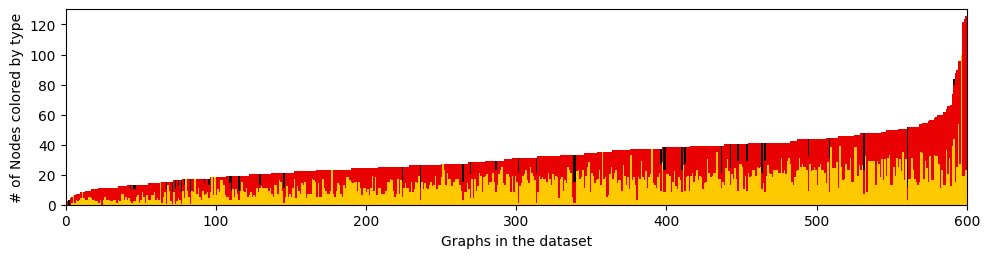

In [9]:
plt.figure(figsize=(10,3))
plt.imshow(M[np.argsort(np.sum(M == -1, axis=1))][::-1].T, cmap='hot_r', interpolation='nearest')
plt.ylabel('# of Nodes colored by type')
plt.xlim(0,600)
plt.ylim(0,130)

plt.xlabel('Graphs in the dataset')
plt.tight_layout()
plt.savefig('dataset_overview.pdf')

In [10]:
def plot_graph(graph, filename):
  G = to_networkx(dataset[graph], to_undirected=True, node_attrs=["x"])
  G.nodes(data=True)

  color = [np.array(x).argmax() for x in nx.get_node_attributes(G, "x").values()]
  nx.set_node_attributes(G, dict([(k, np.array(x).argmax()) for (k, x) in nx.get_node_attributes(G, "x").items()]), "x")

  cmap = plt.cm.hot_r
  norm = plt.Normalize(vmin=-1, vmax=2)
  cdict =  {k: cmap(norm(k)) for k in range(-1, 3)}

  nx.draw(G, node_color=[cdict[f['x']] for n,f in G.nodes(data=True)])
  plt.savefig(filename)

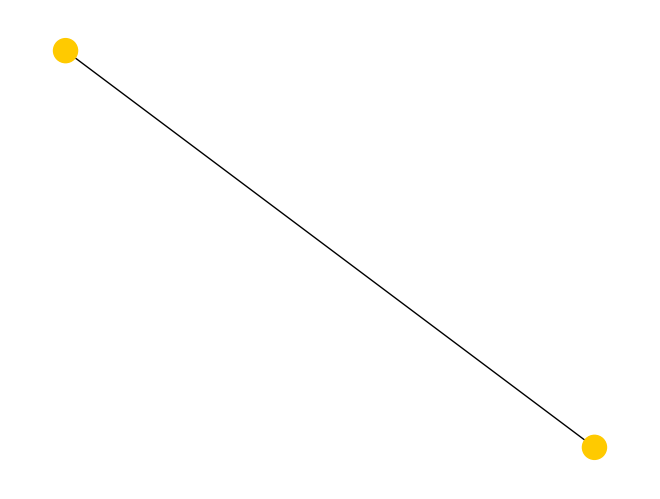

In [11]:
index_in_chart = 1
plot_graph(np.argsort(np.sum(M == -1, axis=1))[-index_in_chart], 'g1.pdf')

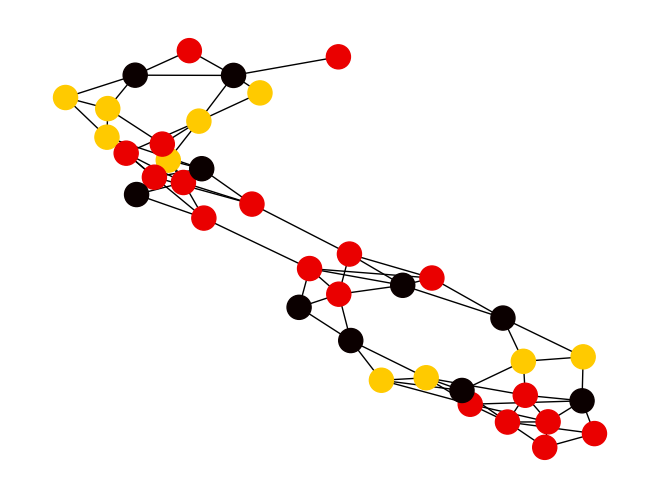

In [12]:
index_in_chart = 397
plot_graph(np.argsort(np.sum(M == -1, axis=1))[-index_in_chart], 'g2.pdf')

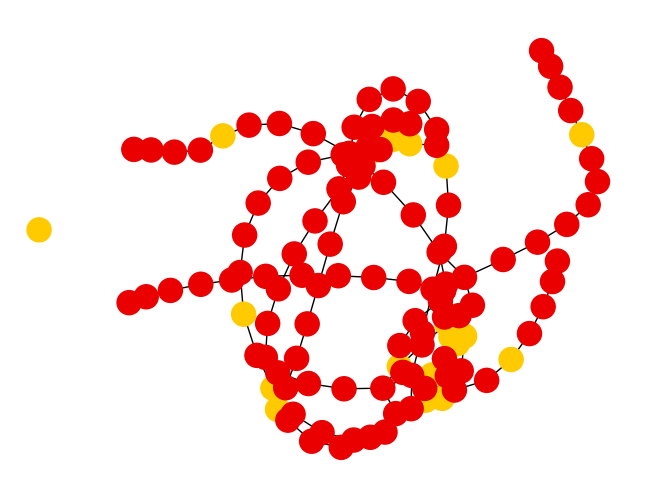

In [13]:
index_in_chart = 599
plot_graph(np.argsort(np.sum(M == -1, axis=1))[-index_in_chart], 'g3.pdf')

# Building Models


### Standard GCN

In [ ]:
class GCNLightning(pl.LightningModule):
    def __init__(self, dim_h):
        super(GCNLightning, self).__init__()
        self.conv1 = GCNConv(3, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.linear = torch.nn.Linear(dim_h, 6)

        self.loss = nn.CrossEntropyLoss()

        self.train_loss = []
        self.train_probabilities = []
        self.train_labels = []

        self.val_loss = []
        self.val_probabilities = []
        self.val_labels = []

    def forward(self, data):
        h = self.conv1(data.x, data.edge_index)
        h = h.relu()
        h = self.conv2(h, data.edge_index)
        h = h.relu()
        h = self.conv3(h, data.edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, data.batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.linear(h)

        return F.log_softmax(h, dim=1), hG

    def compute_loss(self, logits: torch.Tensor, labels: torch.Tensor, validate: bool = False) -> torch.Tensor:
        loss = self.loss(logits, labels)
        return loss

    def training_step(self, batch, batch_idx: int):
        logits, _ = self(batch)
        loss = self.compute_loss(logits, batch.y)
        train_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        train_labels = batch.y.detach().cpu().numpy()

        self.train_loss.append(loss.detach().cpu().numpy())
        self.train_probabilities.append(train_probabilities)
        self.train_labels.append(train_labels)

        return loss

    def test_step(self, batch, batch_idx):
        logits, _ = self(batch)
        test_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        test_labels = batch.y.detach().cpu().numpy()

        test_acc = accuracy_score(test_labels, np.argmax(test_probabilities, axis=-1))
        self.log("test/accuracy", test_acc, prog_bar=False)

    def on_train_epoch_end(self) -> None:
        train_loss = np.mean(self.train_loss)
        self.log("train/loss", train_loss, prog_bar=True)

        train_proba = np.concatenate(self.train_probabilities)
        train_labels = np.concatenate(self.train_labels)

        train_acc = accuracy_score(train_labels, np.argmax(train_proba, axis=-1))
        self.log("train/accuracy", train_acc, prog_bar=False)

        self.train_loss.clear()
        self.train_probabilities.clear()
        self.train_labels.clear()


    def validation_step(self, batch, batch_idx):
        logits, _ = self(batch)
        loss = self.compute_loss(logits, batch.y)
        val_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        val_labels = batch.y.detach().cpu().numpy()

        self.val_loss.append(loss.detach().cpu().numpy())
        self.val_probabilities.append(val_probabilities)
        self.val_labels.append(val_labels)

        return loss

    def on_validation_epoch_end(self) -> None:
        val_loss = np.mean(self.val_loss)
        self.log("val/loss", val_loss, prog_bar=True)

        val_proba = np.concatenate(self.val_probabilities)
        val_labels = np.concatenate(self.val_labels)

        val_acc = accuracy_score(val_labels, np.argmax(val_proba, axis=-1))
        self.log("val/accuracy", val_acc, prog_bar=False)

        self.val_loss.clear()
        self.val_probabilities.clear()
        self.val_labels.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=5e-4)
        return optimizer



### GIN

In [44]:
# inspired by https://mlabonne.github.io/blog/posts/2022-04-25-Graph_Isomorphism_Network.html

class GINLightning(pl.LightningModule):
    def __init__(self, dim_h, lr):
        super(GINLightning, self).__init__()

        self.lr = lr
        self.conv1 = GINConv(
            nn.Sequential(nn.Linear(3, dim_h),
                       nn.BatchNorm1d(dim_h), nn.ReLU(),
                       nn.Linear(dim_h, dim_h), nn.ReLU()))
        self.conv2 = GINConv(
            nn.Sequential(nn.Linear(dim_h, dim_h), nn.BatchNorm1d(dim_h), nn.ReLU(),
                       nn.Linear(dim_h, dim_h), nn.ReLU()))
        self.conv3 = GINConv(
            nn.Sequential(nn.Linear(dim_h, dim_h), nn.BatchNorm1d(dim_h), nn.ReLU(),
                       nn.Linear(dim_h, dim_h), nn.ReLU()))
        self.lin1 = nn.Linear(dim_h*3, dim_h)
        self.lin2 = nn.Linear(dim_h, 6)

        self.loss = nn.CrossEntropyLoss()

        self.train_loss = []
        self.train_probabilities = []
        self.train_labels = []

        self.val_loss = []
        self.val_probabilities = []
        self.val_labels = []

        self.log("dim_h", dim_h)


    def forward(self, data):
        h1 = self.conv1(data.x, data.edge_index)
        h2 = self.conv2(h1, data.edge_index)
        h3 = self.conv3(h2, data.edge_index)

        h1 = global_max_pool(h1, data.batch)
        h2 = global_max_pool(h2, data.batch)
        h3 = global_max_pool(h3, data.batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1), h

    def compute_loss(self, logits: torch.Tensor, labels: torch.Tensor, validate: bool = False) -> torch.Tensor:
        loss = self.loss(logits, labels)
        return loss

    def training_step(self, batch, batch_idx):
        logits, _ = self(batch)
        loss = self.compute_loss(logits, batch.y)
        train_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        train_labels = batch.y.detach().cpu().numpy()

        self.train_loss.append(loss.detach().cpu().numpy())
        self.train_probabilities.append(train_probabilities)
        self.train_labels.append(train_labels)

        return loss

    def validation_step(self, batch, batch_idx):
        logits, _ = self(batch)
        loss = self.compute_loss(logits, batch.y)
        val_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        val_labels = batch.y.detach().cpu().numpy()

        self.val_loss.append(loss.detach().cpu().numpy())
        self.val_probabilities.append(val_probabilities)
        self.val_labels.append(val_labels)

        return loss

    def on_validation_epoch_end(self) -> None:
        val_loss = np.mean(self.val_loss)
        self.log("val/loss", val_loss, prog_bar=True)

        val_proba = np.concatenate(self.val_probabilities)
        val_labels = np.concatenate(self.val_labels)

        val_acc = accuracy_score(val_labels, np.argmax(val_proba, axis=-1))
        self.log("val/accuracy", val_acc, prog_bar=False)

        self.val_loss.clear()
        self.val_probabilities.clear()
        self.val_labels.clear()


    def test_step(self, batch, batch_idx):
        logits, _ = self(batch)
        test_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        test_labels = batch.y.detach().cpu().numpy()

        test_acc = accuracy_score(test_labels, np.argmax(test_probabilities, axis=-1))
        self.log("test/accuracy", test_acc, prog_bar=False)


    def on_train_epoch_end(self) -> None:
        train_loss = np.mean(self.train_loss)
        self.log("train/loss", train_loss, prog_bar=True)

        train_proba = np.concatenate(self.train_probabilities)
        train_labels = np.concatenate(self.train_labels)

        train_acc = accuracy_score(train_labels, np.argmax(train_proba, axis=-1))
        self.log("train/accuracy", train_acc, prog_bar=False)

        self.train_loss.clear()
        self.train_probabilities.clear()
        self.train_labels.clear()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=5e-4)
        return optimizer

### Training Loop

In [ ]:
for seed in [42,43,44]:
    experiment_name = 'gin_seed_'+str(seed)+"_"+str(random.random()*10000)

    dim_h = 64
    batch_size = 64
    lr = 0.001

    model_wrapper = GINLightning(dim_h, lr)
    logger = WandbLogger(project="adlg-gnn", name = experiment_name)

    # We instantiate a Pytorch Lightning trainer
    trainer = pl.Trainer(
        accelerator="cpu",
        max_epochs=200,
        logger=logger,
        log_every_n_steps=50,
        check_val_every_n_epoch=20,
    )

    train_dataset, val_dataset, test_dataset = create_data_splits(dataset, val_size=0, seed=seed)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    logger.log_hyperparams({"batch_size": batch_size, "lr": lr, "dim_h":dim_h})

    trainer.fit(model_wrapper, train_loader)
    name = experiment_name + '.pth'
    trainer.save_checkpoint(name)
    wandb.save(name)

    trainer.test(dataloaders=test_loader, ckpt_path=name)

    wandb.finish()

## Try state of the art architectures

The paper [Graph isomorphism U-Net](https://www.sciencedirect.com/science/article/pii/S0957417423017827?via%3Dihub) includes enhancements to the idea of the GIN by pooling the graph using different centrality measures. The authors report an accuracy of 70% on the ENZYMES dataset.

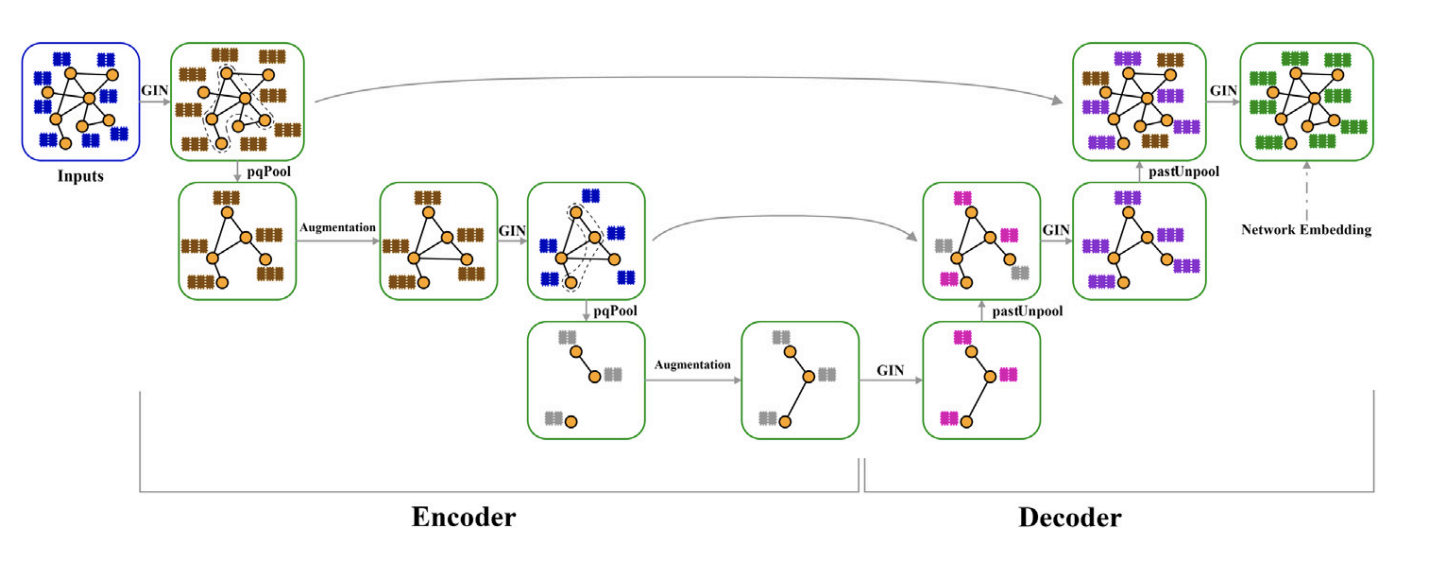



We use their provided [code](https://github.com/aramiracle/GIUNet/blob/main/models.py) and try to train our own model

In [ ]:
def make_convolution(in_channels, out_channels):
    return GINConv(nn.Sequential(
        nn.Linear(in_channels, out_channels),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Linear(out_channels, out_channels),
        nn.BatchNorm1d(out_channels),
        nn.ReLU()
    ))

def calculate_centrality(graph, method, result_queue, index):
    centrality = method(graph)
    result_queue.put((index, centrality))

def extract_numerical_values(centrality_dict):
    # Extract numerical values from the centrality dictionary
    return [value for value in centrality_dict.values()]

# Normalize the graph
def norm_g(g):
    return g / (g.sum(1, keepdim=True) + 1e-8)

# Select top-k graph based on scores
def top_k_pool(scores, edge_index, h, ratio):
    num_nodes = h.shape[0]
    values, idx = torch.topk(scores.squeeze(), max(2, int(ratio * num_nodes)))  # Get top-k values and indices
    new_h = h[idx, :]  # Select top-k nodes
    values = torch.unsqueeze(values, -1)
    new_h = torch.mul(new_h, values)  # Apply weights to nodes
    g = adjacency_matrix(edge_index, num_nodes=num_nodes)  # Create adjacency matrix
    un_g = torch.matmul(g.bool().float(), torch.matmul(g.bool().float(), g.bool().float())).bool().float()  # Calculate unnormalized graph
    un_g = un_g[idx, :][:, idx]  # Select top-k subgraph
    g = norm_g(un_g)  # Normalize the graph
    return g, new_h, idx

# Create adjacency matrix from edge_index
def adjacency_matrix(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max().item() + 1
    adj_matrix = torch.zeros((num_nodes, num_nodes))
    adj_matrix[edge_index[0], edge_index[1]] = 1
    return adj_matrix

# Convert edge_index to NetworkX graph
def edge_index_to_nx_graph(edge_index, num_nodes):
    edge_list = edge_index.t().tolist()
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(edge_list)
    return G

def all_centralities(graph):
    centrality_methods = [
        (nx.algorithms.centrality.closeness_centrality, "closeness_centrality"),
        (nx.algorithms.centrality.degree_centrality, "degree_centrality"),
        (nx.algorithms.centrality.betweenness_centrality, "betweenness_centrality"),
        (nx.algorithms.centrality.load_centrality, "load_centrality"),
        (nx.algorithms.centrality.subgraph_centrality, "subgraph_centrality"),
        (nx.algorithms.centrality.harmonic_centrality, "harmonic_centrality")
    ]

    manager = multiprocessing.Manager()
    result_queue = manager.Queue()
    processes = []

    for index, (method, name) in enumerate(centrality_methods):
        process = multiprocessing.Process(target=calculate_centrality, args=(graph, method, result_queue, index))
        processes.append(process)
        process.start()

    for process in processes:
        process.join()

    centralities_dict = {}
    while not result_queue.empty():
        index, centrality = result_queue.get()
        method_name = centrality_methods[index][1]
        centralities_dict[method_name] = centrality

    # Extract numerical values and convert them to tensors with dtype=float
    centralities = [torch.tensor(extract_numerical_values(centralities_dict[method_name]), dtype=torch.float) for (_, method_name) in centrality_methods]

    return torch.stack(centralities, dim=1)

#Calculating normalized Laplacian of graph
def normalized_laplacian(adjacency_matrix: torch.Tensor) -> torch.Tensor:
    """ Computes the symmetric normalized Laplacian matrix """
    num_nodes = adjacency_matrix.shape[0]
    d = torch.sum(adjacency_matrix, dim=1)
    Dinv_sqrt = torch.diag(1 / torch.sqrt(d))
    Ln = torch.eye(num_nodes, device=adjacency_matrix.device) - torch.mm(torch.mm(Dinv_sqrt, adjacency_matrix), Dinv_sqrt)
    Ln = 0.5 * (Ln + Ln.T)
    return Ln

#Approximataion of eigenvectors of matrix
def approximate_matrix(g, k):
    _, v = scipy.linalg.eigh(g, subset_by_index=[0, min(k - 1, g.shape[0] - 1)])
    return torch.tensor(np.single(v))

# Define a pooling layer for centrality features
class CentPool(nn.Module):
    def __init__(self, in_dim, ratio, p):
        super(CentPool, self).__init__()
        self.ratio = ratio
        self.cent_num = 6
        self.sigmoid = nn.Sigmoid()
        self.feature_proj = nn.Linear(in_dim, 1)
        self.structure_proj = nn.Linear(self.cent_num, 1)
        self.final_proj = nn.Linear(2, 1)
        self.drop = nn.Dropout(p=p) if p > 0 else nn.Identity()

    def forward(self, edge_index, h):
        Z = self.drop(h)
        G = edge_index_to_nx_graph(edge_index, h.shape[0])
        C = all_centralities(G)
        feature_weights = self.feature_proj(Z)
        structure_weights = self.structure_proj(C)
        weights = self.final_proj(torch.cat([feature_weights, structure_weights], dim=1)).squeeze()  # Combine and project weights
        scores = self.sigmoid(weights)
        g, h, idx = top_k_pool(scores, edge_index, h, self.ratio)
        edge_index = edge_index[:, idx]
        return g, h, idx, edge_index

# Define a pooling layer for spectral features
class SpectPool(nn.Module):
    def __init__(self, in_dim, ratio, p):
        super(SpectPool, self).__init__()
        self.ratio = ratio
        self.eigs_num = 3
        self.sigmoid = nn.Sigmoid()
        self.feature_proj = nn.Linear(in_dim, 1)
        self.structure_proj = nn.Linear(self.eigs_num, 1)
        self.final_proj = nn.Linear(2, 1)
        self.drop = nn.Dropout(p=p) if p > 0 else nn.Identity()

    def forward(self, edge_index, h):
        Z = self.drop(h)
        G = edge_index_to_nx_graph(edge_index, h.shape[0])
        L = normalized_laplacian(G)
        L_a = approximate_matrix(L, self.eigs_num)
        feature_weights = self.feature_proj(Z)
        structure_weights = self.structure_proj(L_a)
        weights = self.final_proj(torch.cat([feature_weights, structure_weights], dim=1)).squeeze()  # Combine and project weights
        scores = self.sigmoid(weights)
        g, h, idx = top_k_pool(scores, edge_index, h, self.ratio)
        edge_index = edge_index[:, idx]
        return g, h, idx, edge_index


class SimpleUnpool(nn.Module):
    def forward(self, g, h, idx):
        new_h = h.new_zeros([g.shape[0], h.shape[1]])
        new_h[idx] = h
        return new_h

class Unpool(nn.Module):
    def forward(self, g, h, idx):
        new_h = h.new_zeros([g.shape[0], h.shape[1]])
        new_h[idx] = h
        idx_prime = torch.tensor([index for index in idx if index not in range(g.shape[0])])

        for i in idx_prime:
            normalized_idx = idx.float() / g[i].sum()  # Normalize indices
            weighted_mean = torch.sum(g[i][i] * normalized_idx)  # Compute weighted mean
            new_h[i] = weighted_mean * h

        return new_h

class GIUNetCentLightning(pl.LightningModule):
    def __init__(self, dim_h):
        super(GIUNetCentLightning, self).__init__()
        self.conv1 = make_convolution(3, 32)
        self.pool1 = SpectPool(32, ratio=0.8, p=0.5)  # Custom pooling layer

        self.conv2 = make_convolution(32, 64)
        self.pool2 = SpectPool(64, ratio=0.8, p=0.5)  # Custom pooling layer

        self.midconv = make_convolution(64, 64)

        self.decoder2 = make_convolution(64, 32)
        self.decoder1 = nn.Linear(32, 6)  # Final classification layer

        self.unpool2 = Unpool()  # Unpool layer after decoder2
        self.unpool1 = Unpool()  # Unpool layer after decoder1

        self.loss = nn.CrossEntropyLoss()

        self.train_loss = []
        self.train_probabilities = []
        self.train_labels = []

        self.val_loss = []
        self.val_probabilities = []
        self.val_labels = []


    def forward(self, data):

        x, edge_index, batch = data.x, data.edge_index, data.batch

        x1 = F.relu(self.conv1(x, edge_index))
        g1, x1_pooled, idx1, edge_index1 = self.pool1(edge_index, x1)

        x2 = F.relu(self.conv2(x1_pooled, edge_index1))
        _, x2_pooled, idx2, edge_index2 = self.pool2(edge_index1, x2)

        x_m = F.relu(self.midconv(x2_pooled, edge_index2))

        x_d2 = self.unpool2(g1, x_m, idx2)
        x_d2 = F.relu(self.decoder2(x_d2, edge_index2))

        x_d1 = self.unpool1(adjacency_matrix(edge_index), x_d2, idx1)
        x_d1 = F.relu(self.decoder1(x_d1))

        x_global_pool = global_mean_pool(x_d1, batch)

        return x_global_pool, None

    def compute_loss(self, logits: torch.Tensor, labels: torch.Tensor, validate: bool = False) -> torch.Tensor:
        loss = self.loss(logits, labels)
        return loss

    def training_step(self, batch, batch_idx):
        logits, _ = self(batch)
        loss = self.compute_loss(logits, batch.y)
        train_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        train_labels = batch.y.detach().cpu().numpy()

        self.train_loss.append(loss.detach().cpu().numpy())
        self.train_probabilities.append(train_probabilities)
        self.train_labels.append(train_labels)

        return loss

    def validation_step(self, batch, batch_idx):
        logits, _ = self(batch)
        loss = self.compute_loss(logits, batch.y)
        val_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        val_labels = batch.y.detach().cpu().numpy()

        self.val_loss.append(loss.detach().cpu().numpy())
        self.val_probabilities.append(val_probabilities)
        self.val_labels.append(val_labels)

        return loss

    def on_validation_epoch_end(self) -> None:
        val_loss = np.mean(self.val_loss)
        self.log("val/loss", val_loss, prog_bar=True)

        val_proba = np.concatenate(self.val_probabilities)
        val_labels = np.concatenate(self.val_labels)

        val_acc = accuracy_score(val_labels, np.argmax(val_proba, axis=-1))
        self.log("val/accuracy", val_acc, prog_bar=False)

        self.val_loss.clear()
        self.val_probabilities.clear()
        self.val_labels.clear()


    def test_step(self, batch, batch_idx):
        logits, _ = self(batch)
        test_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        test_labels = batch.y.detach().cpu().numpy()

        test_acc = accuracy_score(test_labels, np.argmax(test_probabilities, axis=-1))
        self.log("test/accuracy", test_acc, prog_bar=False)


    def on_train_epoch_end(self) -> None:
        train_loss = np.mean(self.train_loss)
        self.log("train/loss", train_loss, prog_bar=True)

        train_proba = np.concatenate(self.train_probabilities)
        train_labels = np.concatenate(self.train_labels)

        train_acc = accuracy_score(train_labels, np.argmax(train_proba, axis=-1))
        self.log("train/accuracy", train_acc, prog_bar=False)

        self.train_loss.clear()
        self.train_probabilities.clear()
        self.train_labels.clear()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=5e-4)
        return optimizer

In [ ]:
for seed in [42]:
    experiment_name = 'unet_seed_'+str(seed)+"_"+str(random.random()*10000)
    model_wrapper = GIUNetCentLightning(32)
    logger = WandbLogger(project="adlg-gnn", name = experiment_name)

    # We instantiate a Pytorch Lightning trainer
    trainer = pl.Trainer(
        accelerator="cpu",
        max_epochs=200,
        logger=logger,
        #callbacks=[early_stopping],
        log_every_n_steps=50,
        check_val_every_n_epoch=20,
    )

    train_dataset, val_dataset, test_dataset = create_data_splits(dataset, val_size=0, seed=seed)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    #val_dataset = DataLoader(val_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)


    trainer.fit(model_wrapper, train_loader)
    name = experiment_name + '.pth'
    trainer.save_checkpoint(name)
    wandb.save(name)

    trainer.test(dataloaders=test_loader, ckpt_path=name)


    wandb.finish()

Unfortunately, the training time is very high and our experiments didn't lead to significant improvements compared to the GIN.

## HGP-SL

Another paper that achieves a high accuracy on the ENZYMES dataset is *Hierarchical Graph Pooling with Structure Learning*.

[Paper](https://arxiv.org/abs/1911.05954)

[Code](https://github.com/cszhangzhen/HGP-SL/blob/master/models.py)


Again, we try to apply the model onto our problem.


In [ ]:
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [19]:
from torch.nn import Parameter
from torch_geometric.data import Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import softmax, dense_to_sparse, add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_scatter import scatter_add, scatter_max
from torch_sparse import spspmm, coalesce
import torch_scatter

def filter_adj(edge_index, edge_attr, perm, num_nodes=None):
    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    mask = perm.new_full((num_nodes, ), -1)
    i = torch.arange(perm.size(0), dtype=torch.long, device=perm.device)
    mask[perm] = i

    row, col = edge_index
    row, col = mask[row], mask[col]
    mask = (row >= 0) & (col >= 0)
    row, col = row[mask], col[mask]

    if edge_attr is not None:
        edge_attr = edge_attr[mask]

    return torch.stack([row, col], dim=0), edge_attr

def topk(x, ratio, batch, min_score=None, tol=1e-7):
    if min_score is not None:
        # Make sure that we do not drop all nodes in a graph.
        scores_max = scatter_max(x, batch)[0][batch] - tol
        scores_min = scores_max.clamp(max=min_score)

        perm = (x > scores_min).nonzero(as_tuple=False).view(-1)
    else:
        num_nodes = scatter_add(batch.new_ones(x.size(0)), batch, dim=0)
        batch_size, max_num_nodes = num_nodes.size(0), num_nodes.max().item()

        cum_num_nodes = torch.cat(
            [num_nodes.new_zeros(1),
             num_nodes.cumsum(dim=0)[:-1]], dim=0)

        index = torch.arange(batch.size(0), dtype=torch.long, device=x.device)
        index = (index - cum_num_nodes[batch]) + (batch * max_num_nodes)

        dense_x = x.new_full((batch_size * max_num_nodes, ),
                             torch.finfo(x.dtype).min)
        dense_x[index] = x
        dense_x = dense_x.view(batch_size, max_num_nodes)

        _, perm = dense_x.sort(dim=-1, descending=True)

        perm = perm + cum_num_nodes.view(-1, 1)
        perm = perm.view(-1)

        if isinstance(ratio, int):
            k = num_nodes.new_full((num_nodes.size(0), ), ratio)
            k = torch.min(k, num_nodes)
        else:
            k = (ratio * num_nodes.to(torch.float)).ceil().to(torch.long)

        mask = [
            torch.arange(k[i], dtype=torch.long, device=x.device) +
            i * max_num_nodes for i in range(batch_size)
        ]
        mask = torch.cat(mask, dim=0)

        perm = perm[mask]

    return perm

def scatter_sort(x, batch, fill_value=-1e16):
    num_nodes = scatter_add(batch.new_ones(x.size(0)), batch, dim=0)
    batch_size, max_num_nodes = num_nodes.size(0), num_nodes.max().item()

    cum_num_nodes = torch.cat([num_nodes.new_zeros(1), num_nodes.cumsum(dim=0)[:-1]], dim=0)

    index = torch.arange(batch.size(0), dtype=torch.long, device=x.device)
    index = (index - cum_num_nodes[batch]) + (batch * max_num_nodes)

    dense_x = x.new_full((batch_size * max_num_nodes,), fill_value)
    dense_x[index] = x
    dense_x = dense_x.view(batch_size, max_num_nodes)

    sorted_x, _ = dense_x.sort(dim=-1, descending=True)
    cumsum_sorted_x = sorted_x.cumsum(dim=-1)
    cumsum_sorted_x = cumsum_sorted_x.view(-1)

    sorted_x = sorted_x.view(-1)
    filled_index = sorted_x != fill_value

    sorted_x = sorted_x[filled_index]
    cumsum_sorted_x = cumsum_sorted_x[filled_index]

    return sorted_x, cumsum_sorted_x


def _make_ix_like(batch):
    num_nodes = scatter_add(batch.new_ones(batch.size(0)), batch, dim=0)
    idx = [torch.arange(1, i + 1, dtype=torch.long, device=batch.device) for i in num_nodes]
    idx = torch.cat(idx, dim=0)

    return idx


def _threshold_and_support(x, batch):
    """Sparsemax building block: compute the threshold
    Args:
        x: input tensor to apply the sparsemax
        batch: group indicators
    Returns:
        the threshold value
    """
    num_nodes = scatter_add(batch.new_ones(x.size(0)), batch, dim=0)
    cum_num_nodes = torch.cat([num_nodes.new_zeros(1), num_nodes.cumsum(dim=0)[:-1]], dim=0)

    sorted_input, input_cumsum = scatter_sort(x, batch)
    input_cumsum = input_cumsum - 1.0
    rhos = _make_ix_like(batch).to(x.dtype)
    support = rhos * sorted_input > input_cumsum

    support_size = scatter_add(support.to(batch.dtype), batch)
    # mask invalid index, for example, if batch is not start from 0 or not continuous, it may result in negative index
    idx = support_size + cum_num_nodes - 1
    mask = idx < 0
    idx[mask] = 0
    tau = input_cumsum.gather(0, idx)
    tau /= support_size.to(x.dtype)

    return tau, support_size


class SparsemaxFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, batch):
        """sparsemax: normalizing sparse transform
        Parameters:
            ctx: context object
            x (Tensor): shape (N, )
            batch: group indicator
        Returns:
            output (Tensor): same shape as input
        """
        max_val, _ = scatter_max(x, batch)
        x -= max_val[batch]
        tau, supp_size = _threshold_and_support(x, batch)
        output = torch.clamp(x - tau[batch], min=0)
        ctx.save_for_backward(supp_size, output, batch)

        return output

    @staticmethod
    def backward(ctx, grad_output):
        supp_size, output, batch = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[output == 0] = 0

        v_hat = scatter_add(grad_input, batch) / supp_size.to(output.dtype)
        grad_input = torch.where(output != 0, grad_input - v_hat[batch], grad_input)

        return grad_input, None


sparsemax = SparsemaxFunction.apply


class Sparsemax(nn.Module):

    def __init__(self):
        super(Sparsemax, self).__init__()

    def forward(self, x, batch):
        return sparsemax(x, batch)

class TwoHopNeighborhood(object):
    def __call__(self, data):
        edge_index, edge_attr = data.edge_index, data.edge_attr
        n = data.num_nodes

        fill = 1e16
        value = edge_index.new_full((edge_index.size(1),), fill, dtype=torch.float)

        index, value = spspmm(edge_index, value, edge_index, value, n, n, n, True)

        edge_index = torch.cat([edge_index, index], dim=1)
        if edge_attr is None:
            data.edge_index, _ = coalesce(edge_index, None, n, n)
        else:
            value = value.view(-1, *[1 for _ in range(edge_attr.dim() - 1)])
            value = value.expand(-1, *list(edge_attr.size())[1:])
            edge_attr = torch.cat([edge_attr, value], dim=0)
            data.edge_index, edge_attr = coalesce(edge_index, edge_attr, n, n, op='min')
            edge_attr[edge_attr >= fill] = 0
            data.edge_attr = edge_attr

        return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)


class GCN(MessagePassing):
    def __init__(self, in_channels, out_channels, cached=False, bias=True, **kwargs):
        super(GCN, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.cached = cached
        self.cached_result = None
        self.cached_num_edges = None

        self.weight = Parameter(torch.Tensor(in_channels, out_channels))
        nn.init.xavier_uniform_(self.weight.data)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
            nn.init.zeros_(self.bias.data)
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.cached_result = None
        self.cached_num_edges = None

    @staticmethod
    def norm(edge_index, num_nodes, edge_weight, dtype=None):
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype, device=edge_index.device)

        row, col = edge_index
        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    def forward(self, x, edge_index, edge_weight=None):
        x = torch.matmul(x, self.weight)

        if self.cached and self.cached_result is not None:
            if edge_index.size(1) != self.cached_num_edges:
                raise RuntimeError(
                    'Cached {} number of edges, but found {}'.format(self.cached_num_edges, edge_index.size(1)))

        if not self.cached or self.cached_result is None:
            self.cached_num_edges = edge_index.size(1)
            edge_index, norm = self.norm(edge_index, x.size(0), edge_weight, x.dtype)
            self.cached_result = edge_index, norm

        edge_index, norm = self.cached_result

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)


class NodeInformationScore(MessagePassing):
    def __init__(self, improved=False, cached=False, **kwargs):
        super(NodeInformationScore, self).__init__(aggr='add', **kwargs)

        self.improved = improved
        self.cached = cached
        self.cached_result = None
        self.cached_num_edges = None

    @staticmethod
    def norm(edge_index, num_nodes, edge_weight, dtype=None):
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype, device=edge_index.device)

        row, col = edge_index
        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        edge_index, edge_weight = add_remaining_self_loops(edge_index, edge_weight, 0, num_nodes)

        row, col = edge_index
        expand_deg = torch.zeros((edge_weight.size(0),), dtype=dtype, device=edge_index.device)
        expand_deg[-num_nodes:] = torch.ones((num_nodes,), dtype=dtype, device=edge_index.device)

        return edge_index, expand_deg - deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    def forward(self, x, edge_index, edge_weight):
        if self.cached and self.cached_result is not None:
            if edge_index.size(1) != self.cached_num_edges:
                raise RuntimeError(
                    'Cached {} number of edges, but found {}'.format(self.cached_num_edges, edge_index.size(1)))

        if not self.cached or self.cached_result is None:
            self.cached_num_edges = edge_index.size(1)
            edge_index, norm = self.norm(edge_index, x.size(0), edge_weight, x.dtype)
            self.cached_result = edge_index, norm

        edge_index, norm = self.cached_result

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out


class HGPSLPool(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        ratio=0.8,
        sample=False,
        sparse=False,
        sl=True,
        lamb=1.0,
        negative_slop=0.2,
    ):
        super(HGPSLPool, self).__init__()
        self.in_channels = in_channels
        self.ratio = ratio
        self.sample = sample
        self.sparse = sparse
        self.sl = sl
        self.negative_slop = negative_slop
        self.lamb = lamb

        self.att = Parameter(torch.Tensor(1, self.in_channels * 2))
        nn.init.xavier_uniform_(self.att.data)
        self.sparse_attention = Sparsemax()
        self.neighbor_augment = TwoHopNeighborhood()
        self.calc_information_score = NodeInformationScore()

    def forward(self, x, edge_index, edge_attr, batch=None):
        if batch is None:
            batch = edge_index.new_zeros(x.size(0))

        x_information_score = self.calc_information_score(x, edge_index, edge_attr)
        score = torch.sum(torch.abs(x_information_score), dim=1)

        # Graph Pooling
        original_x = x
        perm = topk(score, self.ratio, batch)
        x = x[perm]
        batch = batch[perm]
        induced_edge_index, induced_edge_attr = filter_adj(edge_index, edge_attr, perm, num_nodes=score.size(0))

        # Discard structure learning layer, directly return
        if self.sl is False:
            return x, induced_edge_index, induced_edge_attr, batch

        # Structure Learning
        if self.sample:
            # A fast mode for large graphs.
            # In large graphs, learning the possible edge weights between each pair of nodes is time consuming.
            # To accelerate this process, we sample it's K-Hop neighbors for each node and then learn the
            # edge weights between them.
            k_hop = 3
            if edge_attr is None:
                edge_attr = torch.ones((edge_index.size(1),), dtype=torch.float, device=edge_index.device)

            hop_data = Data(x=original_x, edge_index=edge_index, edge_attr=edge_attr)
            for _ in range(k_hop - 1):
                hop_data = self.neighbor_augment(hop_data)
            hop_edge_index = hop_data.edge_index
            hop_edge_attr = hop_data.edge_attr
            new_edge_index, new_edge_attr = filter_adj(hop_edge_index, hop_edge_attr, perm, num_nodes=score.size(0))

            new_edge_index, new_edge_attr = add_remaining_self_loops(new_edge_index, new_edge_attr, 0, x.size(0))
            row, col = new_edge_index
            weights = (torch.cat([x[row], x[col]], dim=1) * self.att).sum(dim=-1)
            weights = F.leaky_relu(weights, self.negative_slop) + new_edge_attr * self.lamb
            adj = torch.zeros((x.size(0), x.size(0)), dtype=torch.float, device=x.device)
            adj[row, col] = weights
            new_edge_index, weights = dense_to_sparse(adj)
            row, col = new_edge_index
            if self.sparse:
                new_edge_attr = self.sparse_attention(weights, row)
            else:
                new_edge_attr = softmax(weights, row, x.size(0))
            # filter out zero weight edges
            adj[row, col] = new_edge_attr
            new_edge_index, new_edge_attr = dense_to_sparse(adj)
            # release gpu memory
            del adj
            torch.cuda.empty_cache()
        else:
            # Learning the possible edge weights between each pair of nodes in the pooled subgraph, relative slower.
            if edge_attr is None:
                induced_edge_attr = torch.ones(
                    (induced_edge_index.size(1),),
                    dtype=x.dtype,
                    device=induced_edge_index.device,
                )
            num_nodes = scatter_add(batch.new_ones(x.size(0)), batch, dim=0)
            shift_cum_num_nodes = torch.cat([num_nodes.new_zeros(1), num_nodes.cumsum(dim=0)[:-1]], dim=0)
            cum_num_nodes = num_nodes.cumsum(dim=0)
            adj = torch.zeros((x.size(0), x.size(0)), dtype=torch.float, device=x.device)
            # Construct batch fully connected graph in block diagonal matirx format
            for idx_i, idx_j in zip(shift_cum_num_nodes, cum_num_nodes):
                adj[idx_i:idx_j, idx_i:idx_j] = 1.0
            new_edge_index, _ = dense_to_sparse(adj)
            row, col = new_edge_index

            weights = (torch.cat([x[row], x[col]], dim=1) * self.att).sum(dim=-1)
            weights = F.leaky_relu(weights, self.negative_slop)
            adj[row, col] = weights
            induced_row, induced_col = induced_edge_index

            adj[induced_row, induced_col] += induced_edge_attr * self.lamb
            weights = adj[row, col]
            if self.sparse:
                new_edge_attr = self.sparse_attention(weights, row)
            else:
                new_edge_attr = softmax(weights, row, x.size(0))
            # filter out zero weight edges
            adj[row, col] = new_edge_attr
            new_edge_index, new_edge_attr = dense_to_sparse(adj)
            # release gpu memory
            del adj
            torch.cuda.empty_cache()

        return x, new_edge_index, new_edge_attr, batch

class HPGSLLightning(pl.LightningModule):
    def __init__(self, dim_h, lr):
        super(HPGSLLightning, self).__init__()

        self.lr = lr
        self.num_features = 3
        self.nhid = dim_h
        self.num_classes = 6
        self.pooling_ratio = 0.8
        self.dropout_ratio = 0.5
        self.sample = True
        self.sparse = True
        self.sl = True
        self.lamb = 1.0

        self.conv1 = GCNConv(self.num_features, self.nhid)
        self.conv2 = GCN(self.nhid, self.nhid)
        self.conv3 = GCN(self.nhid, self.nhid)

        self.pool1 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)
        self.pool2 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)

        self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)
        self.lin2 = torch.nn.Linear(self.nhid, self.nhid // 2)
        self.lin3 = torch.nn.Linear(self.nhid // 2, self.num_classes)

        self.loss = nn.CrossEntropyLoss()

        self.train_loss = []
        self.train_probabilities = []
        self.train_labels = []

        self.val_loss = []
        self.val_probabilities = []
        self.val_labels = []


    def forward(self, data):

        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = None

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool1(x, edge_index, edge_attr, batch)
        x1 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool2(x, edge_index, edge_attr, batch)
        x2 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x3 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(x1) + F.relu(x2) + F.relu(x3)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x, None

    def compute_loss(self, logits: torch.Tensor, labels: torch.Tensor, validate: bool = False) -> torch.Tensor:
        loss = self.loss(logits, labels)
        return loss

    def training_step(self, batch, batch_idx):
        logits, _ = self(batch)
        loss = self.compute_loss(logits, batch.y)
        train_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        train_labels = batch.y.detach().cpu().numpy()

        self.train_loss.append(loss.detach().cpu().numpy())
        self.train_probabilities.append(train_probabilities)
        self.train_labels.append(train_labels)

        return loss

    def validation_step(self, batch, batch_idx):
        logits, _ = self(batch)
        loss = self.compute_loss(logits, batch.y)
        val_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        val_labels = batch.y.detach().cpu().numpy()

        self.val_loss.append(loss.detach().cpu().numpy())
        self.val_probabilities.append(val_probabilities)
        self.val_labels.append(val_labels)

        return loss

    def on_validation_epoch_end(self) -> None:
        val_loss = np.mean(self.val_loss)
        self.log("val/loss", val_loss, prog_bar=True)

        val_proba = np.concatenate(self.val_probabilities)
        val_labels = np.concatenate(self.val_labels)

        val_acc = accuracy_score(val_labels, np.argmax(val_proba, axis=-1))
        self.log("val/accuracy", val_acc, prog_bar=False)

        self.val_loss.clear()
        self.val_probabilities.clear()
        self.val_labels.clear()


    def test_step(self, batch, batch_idx):
        logits, _ = self(batch)
        test_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        test_labels = batch.y.detach().cpu().numpy()

        test_acc = accuracy_score(test_labels, np.argmax(test_probabilities, axis=-1))
        self.log("test/accuracy", test_acc, prog_bar=False)


    def on_train_epoch_end(self) -> None:
        train_loss = np.mean(self.train_loss)
        self.log("train/loss", train_loss, prog_bar=True)

        train_proba = np.concatenate(self.train_probabilities)
        train_labels = np.concatenate(self.train_labels)

        train_acc = accuracy_score(train_labels, np.argmax(train_proba, axis=-1))
        self.log("train/accuracy", train_acc, prog_bar=False)

        self.train_loss.clear()
        self.train_probabilities.clear()
        self.train_labels.clear()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=5e-4)
        return optimizer

### Training

In [ ]:
for seed in [42, 43, 44]:
    experiment_name = 'hpgsl_seed_'+str(seed)+"_"+str(random.random()*10000)
    model_wrapper = HPGSLLightning(64)
    logger = WandbLogger(project="adlg-gnn", name = experiment_name)

    dim_h = 64
    batch_size = 64
    lr = 0.001

    trainer = pl.Trainer(
        accelerator="cpu",
        max_epochs=200,
        logger=logger,
        log_every_n_steps=50,
        check_val_every_n_epoch=20,
    )

    train_dataset, val_dataset, test_dataset = create_data_splits(dataset, val_size=0, seed=seed)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    trainer.fit(model_wrapper, train_loader)
    name = experiment_name + '.pth'
    trainer.save_checkpoint(name)
    wandb.save(name)

    trainer.test(dataloaders=test_loader, ckpt_path=name)

    wandb.finish()

## Shortest path networks for graph property prediction

The authors propose shortest path message passing neural networks, where the node representations of a graph are propagated to each node in the shortest path neighborhoods.

[Paper](https://arxiv.org/abs/2206.01003)

[Code](https://github.com/radoslav11/SP-MPNN)


In [ ]:
import torch
from torch.nn import MultiheadAttention
from torch.nn import Linear, ReLU, BatchNorm1d
from torch.nn import ModuleList, Sequential, Embedding
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F
from torch_scatter import scatter_mean

avail_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def instantiate_mlp(
    in_channels,
    out_channels,
    device=avail_device,
    final_activation=True,
    batch_norm=True,
):
    if final_activation:
        if batch_norm:
            mlp_mods = ModuleList(
                [
                    Linear(in_channels, out_channels).to(device),
                    BatchNorm1d(out_channels).to(device),
                    ReLU().to(device),
                    Linear(out_channels, out_channels).to(device),
                    BatchNorm1d(out_channels).to(device),
                    ReLU().to(device),
                ]
            ).to(device)
        else:
            mlp_mods = ModuleList(
                [
                    Linear(in_channels, out_channels).to(device),
                    ReLU().to(device),
                    Linear(out_channels, out_channels).to(device),
                    ReLU().to(device),
                ]
            ).to(device)
    else:
        if batch_norm:
            mlp_mods = ModuleList(
                [
                    Linear(in_channels, out_channels).to(device),
                    BatchNorm1d(out_channels).to(device),
                    ReLU().to(device),
                    Linear(out_channels, out_channels).to(device),
                ]
            ).to(device)
        else:
            mlp_mods = ModuleList(
                [
                    Linear(in_channels, out_channels).to(device),
                    ReLU().to(device),
                    Linear(out_channels, out_channels).to(device),
                ]
            ).to(device)

    return Sequential(*mlp_mods).to(device)


class GIN_HSP_Layer(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        max_distance,
        eps=0.0,
        inside_aggr="sum",
        outside_aggr="weight",
        nhead=8,
        nb_edge_types=1,
        batch_norm=True,
        edgesum_relu=True,
        dataset=None,
        device=avail_device,
    ):
        """
        :param in_channels: Dimension size of input. We denote this by I.
        :param out_channels: Dimension size of output: We denote this by O.
        :param max_distance: Maximal shortest distance we're considering.
                             By K we will denote max_distance + 1, so that we
                             take into account the node itself (i.e. distance = 0).
        :param eps: The epsilon value used by GIN
        :param inside_aggr: The aggregation function used inside every hop
        :param outside_aggr: The overall aggregation function used to combine all hop representations
        :param nhead: (For attention outside agg) The number of attention heads
        :param batch_norm: A Boolean specifying whether batch norm is used inside the model MLPs
        """
        super(GIN_HSP_Layer, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.max_distance = max_distance
        self.nb_edge_types = nb_edge_types
        self.dataset = dataset

        # The aggregation function of the neighbours on each level
        if (
            inside_aggr[0] == "r"
        ):  # Using a ``relational'' variant. Define the necessary MLPs
            # Keep the dimensionality constant inside, prior to applying the final MLP
            self.loop_mlp = instantiate_mlp(
                in_channels=in_channels,
                out_channels=in_channels,
                device=device,
                final_activation=False,
                batch_norm=batch_norm,
            )
            self.rel_mlps = ModuleList(
                [
                    instantiate_mlp(
                        in_channels=in_channels,
                        out_channels=in_channels,
                        device=device,
                        final_activation=False,
                        batch_norm=batch_norm,
                    )
                    for i in range(nb_edge_types)
                ]
            )
            self.higher_hop_mlp = instantiate_mlp(
                in_channels=in_channels,
                out_channels=in_channels,
                device=device,
                final_activation=False,
                batch_norm=batch_norm,
            )
        self.gin_mlp = instantiate_mlp(
            in_channels=in_channels,
            out_channels=out_channels,
            device=device,
            final_activation=True,
            batch_norm=batch_norm,
        )

        self.edgesum_relu = edgesum_relu
        self.eps_val = eps
        self.eps = eps
        self.device = device

        self.inside_aggr = inside_aggr
        if inside_aggr == "attn_nh":
            self.hop_level_attn = ModuleList(
                [
                    MultiheadAttention(
                        embed_dim=self.in_channels, num_heads=nhead, batch_first=True
                    ).to(device)
                    for _ in range(self.max_distance)
                ]
            )
        elif inside_aggr == "global_attn_nh":
            self.hop_level_attn = ModuleList(
                [
                    MultiheadAttention(
                        embed_dim=self.in_channels, num_heads=nhead, batch_first=True
                    ).to(device)
                    for _ in range(self.max_distance)
                ]
            )

        if self.dataset and self.dataset in [
            "MUV",
            "HIV",
            "BACE",
            "BBBP",
            "Tox21",
            "ToxCast",
            "SIDER",
            "ClinTox",
        ]:
            self.bond_embedding = Embedding(5, in_channels)
            self.direction_embedding = Embedding(3, in_channels)

        self.outside_aggr = outside_aggr
        if outside_aggr in ["weight", "eps_weight"]:
            self.hop_coef = torch.nn.Parameter(
                torch.randn(self.max_distance).to(device), requires_grad=True
            )
            if outside_aggr == "eps_weight":
                self.eps = torch.nn.Parameter(
                    torch.randn(1).to(device), requires_grad=True
                )

    def forward(
        self,
        node_embeddings,
        edge_index,
        edge_weights,
        batch=None,
        edge_attr=None,
        direct_edge_embs=None,
    ):
        """
        :param node_embeddings: A FloatTensor of shape [N, In_dim]
        :param edge_index: A LongTensor of shape [2, #Edges]
        :param edge_weights: The weights by SP_length
        :param batch: The batch size
        :param edge_attr: (For multi-relational graphs) The edge types for
        :param direct_edge_embs: (For OGBG datasets), edge attributes that are summed with node attributes
        (then passed through ReLU).
        :return: A forward propagation of the input through the HSP layer
        """
        if self.dataset and self.dataset in [
            "MUV",
            "HIV",
            "BACE",
            "BBBP",
            "Tox21",
            "ToxCast",
            "SIDER",
            "ClinTox",
        ]:  # Refactor
            direct_edge_attr = edge_attr[
                edge_weights == 1, :
            ]  # Fetch the direct edge attributes
            direct_edge_embs = self.bond_embedding(
                direct_edge_attr[:, 0]
            ) + self.direction_embedding(direct_edge_attr[:, 1])

        nb_nodes = node_embeddings.size(0)  # Number of nodes
        unsq_node_embeddings = node_embeddings.unsqueeze(
            0
        )  # Unsqueezed embeddings, shape [1, N, In_Dim]
        if self.inside_aggr == "sum":
            by_hop_aggregates = torch.zeros(
                size=(self.max_distance, nb_nodes, self.in_channels), dtype=torch.float
            ).to(
                self.device
            )  # A [K, N, I] tensor
            for d in range(1, self.max_distance + 1):
                edges = edge_index.T[edge_weights == d].T  # Fetch the edges
                if edges.numel() != 0:
                    values = torch.ones(edges.shape[1], dtype=torch.float).to(
                        self.device
                    )
                    sparse_adjacency_d = torch.sparse_coo_tensor(
                        edges, values, (nb_nodes, nb_nodes)
                    )  # [N,N] SpTensor
                    by_hop_aggregates[d - 1, :, :] = torch.sparse.mm(
                        sparse_adjacency_d, node_embeddings
                    )
        elif (
            self.inside_aggr == "edgesum"
        ):  # Summing while accounting for edge attributes (OGBG datasets)
            if direct_edge_embs is not None:
                by_hop_aggregates = torch.zeros(
                    size=(self.max_distance, nb_nodes, self.in_channels),
                    dtype=torch.float,
                ).to(
                    self.device
                )  # A [K, N, I] tensor
                edges_direct = edge_index.T[
                    edge_weights == 1
                ].T  # Fetch the direct edges

                # K=1: Like OGB, sum node and edge attr, then apply a ReLU
                if edges_direct.numel() != 0:
                    # Link nodes to edges
                    nb_edges = edges_direct.shape[1]
                    edge_links = torch.cat(
                        (
                            edges_direct[0:1, :],
                            torch.arange(nb_edges).unsqueeze(0).to(self.device),
                        ),
                        dim=0,
                    )
                    values = torch.ones(edges_direct.shape[1], dtype=torch.float).to(
                        self.device
                    )
                    sparse_edge_adjacency = torch.sparse_coo_tensor(
                        edge_links, values, (nb_nodes, nb_edges)
                    )
                    destination_node_embeddings = node_embeddings[
                        edges_direct[1, :]
                    ]  # [nb_edges, d]

                    messages = destination_node_embeddings + direct_edge_embs
                    if self.edgesum_relu:
                        messages = torch.relu(messages)

                    by_hop_aggregates[0, :, :] = torch.sparse.mm(
                        sparse_edge_adjacency, messages
                    )

                # Now K=2 and above as standard
                for d in range(2, self.max_distance + 1):
                    edges = edge_index.T[edge_weights == d].T  # Fetch the edges
                    if edges.numel() != 0:
                        values = torch.ones(edges.shape[1], dtype=torch.float).to(
                            self.device
                        )
                        sparse_adjacency_d = torch.sparse_coo_tensor(
                            edges, values, (nb_nodes, nb_nodes)
                        )  # [N,N] SpTensor
                        by_hop_aggregates[d - 1, :, :] = torch.sparse.mm(
                            sparse_adjacency_d, node_embeddings
                        )
            else:
                raise AttributeError("Edge Embeddings not provided")

        elif self.inside_aggr == "rsum":
            assert edge_attr is not None
            by_hop_aggregates = torch.zeros(
                size=(self.max_distance, nb_nodes, self.in_channels), dtype=torch.float
            ).to(
                self.device
            )  # A [K, N, I] tensor
            # First step: k=1...
            for t in range(self.nb_edge_types):
                edges_direct_t = edge_index.T[
                    torch.logical_and(edge_weights == 1, edge_attr == t)
                ].T
                if edges_direct_t.numel() != 0:
                    values = torch.ones(edges_direct_t.shape[1], dtype=torch.float).to(
                        self.device
                    )
                    transformed_node_emb = self.rel_mlps[t](node_embeddings)
                    sparse_adjacency_t = torch.sparse_coo_tensor(
                        edges_direct_t, values, (nb_nodes, nb_nodes)
                    )
                    by_hop_aggregates[0, :, :] += torch.sparse.mm(
                        sparse_adjacency_t, transformed_node_emb
                    )  # Add
            # Second step: k>=2, just like before
            indirect_transform_node_emb = self.higher_hop_mlp(
                node_embeddings
            )  # These are the transf representations
            for d in range(2, self.max_distance + 1):
                edges = edge_index.T[edge_weights == d].T  # Fetch the edges
                if edges.numel() != 0:
                    values = torch.ones(edges.shape[1], dtype=torch.float).to(
                        self.device
                    )
                    sparse_adjacency_d = torch.sparse_coo_tensor(
                        edges, values, (nb_nodes, nb_nodes)
                    )  # [N,N] SpTensor
                    by_hop_aggregates[d - 1, :, :] = torch.sparse.mm(
                        sparse_adjacency_d, indirect_transform_node_emb
                    )
        else:
            hops__K_N_N = torch.zeros(
                size=(self.max_distance, nb_nodes, nb_nodes), dtype=torch.float
            ).to(self.device)
            for d in range(1, self.max_distance + 1):
                edges = edge_index.T[edge_weights == d].T
                if edges.numel() != 0:
                    hops__K_N_N[d - 1] = to_dense_adj(edges, max_num_nodes=nb_nodes)[0]

        if self.inside_aggr == "attn_nh":
            by_hop_aggregates = torch.zeros(
                size=(self.max_distance, nb_nodes, self.in_channels), dtype=torch.float
            ).to(self.device)
            for d, attn_layer in enumerate(self.hop_level_attn):
                # Torch standard attention returns nan, when there are no neighbours.
                # As we use attention as a generalisation of sum, the value of the embedding should be 0 in this case.
                nan_inverse_node_mask = hops__K_N_N[d].sum(axis=1) != 0
                if nan_inverse_node_mask.sum() == 0:
                    continue  # Skip if the attn mask is empty

                nodes_for_attn = unsq_node_embeddings[:, nan_inverse_node_mask, :]
                attn_mask = (
                    hops__K_N_N[d, nan_inverse_node_mask, :][:, nan_inverse_node_mask]
                    < 1
                )
                if self.inside_aggr == "attn_nh":
                    query = nodes_for_attn
                elif self.inside_aggr == "global_attn_nh":
                    pooled = scatter_mean(node_embeddings, batch, dim=0).to(self.device)
                    mean_emb__N_I = pooled[batch]
                    query = mean_emb__N_I[nan_inverse_node_mask].unsqueeze(0)

                after_attn__1_N_I, _ = attn_layer(
                    query, nodes_for_attn, nodes_for_attn, attn_mask=attn_mask
                )
                by_hop_aggregates[d, nan_inverse_node_mask, :] = after_attn__1_N_I[0]

        if self.outside_aggr in ["eps_weight", "weight"]:
            overall_hop_aggr = (
                (by_hop_aggregates.T * F.softmax(self.hop_coef, dim=0))
                .T.sum(axis=0)
                .to(self.device)
            )
        elif self.outside_aggr == "sum":
            overall_hop_aggr = by_hop_aggregates.sum(axis=0).to(
                self.device
            )  # overall_hop_aggr is [N, In]

        if self.inside_aggr != "rsum":  # Standard GIN
            out_embeddings = self.gin_mlp(
                (self.eps + 1) * node_embeddings.to(self.device) + overall_hop_aggr
            )
        else:  # No overall MLP, just a non-linearity (sigmoid, following GNN-FiLM equation)
            out_embeddings = (self.eps + 1) * self.loop_mlp(node_embeddings).to(
                self.device
            ) + overall_hop_aggr

        return out_embeddings

    def reset_parameters(self):
        for (name, module) in self._modules.items():
            if hasattr(module, "reset_parameters"):
                module.reset_parameters()
        for x in self.gin_mlp:
            if hasattr(x, "reset_parameters"):
                x.reset_parameters()
        if self.inside_aggr[0] == "r":  # Relational model
            for mlp in self.rel_mlps:
                for x in mlp:
                    if hasattr(x, "reset_parameters"):
                        x.reset_parameters()
            for x in self.loop_mlp:
                if hasattr(x, "reset_parameters"):
                    x.reset_parameters()

        if self.outside_aggr in ["weight", "eps_weight"]:
            torch.nn.init.normal_(self.hop_coef.data)
            if self.outside_aggr == "eps_weight":
                torch.nn.init.normal_(self.eps.data, mean=self.eps_val)

        if self.inside_aggr == "attn_nh":
            for module in self.hop_level_attn:
                for child in module.children():
                    child.reset_parameters()

Using the defined network

In [ ]:
class HSP_Lightning(pl.LightningModule):
    def __init__(self, dim_h):
        super(HSP_Lightning, self).__init__()
        self.conv1 = make_convolution(3, 32)
        self.hsp1 = GIN_HSP_Layer(
                in_channels=32,
                out_channels=32,
                eps=0,
                max_distance=5,
                inside_aggr="attn_nh",
                outside_aggr="eps_weight",
                batch_norm=True,
                dataset=dataset,
                device='cpu'
            )

        self.hsp2 = GIN_HSP_Layer(
                in_channels=32,
                out_channels=32,
                eps=0,
                max_distance=5,
                inside_aggr="attn_nh",
                outside_aggr="eps_weight",
                batch_norm=True,
                dataset=dataset,
                device='cpu'
            )
        self.decoder = nn.Linear(32, 6)  # Final classification layer

        self.loss = nn.CrossEntropyLoss()

        self.train_loss = []
        self.train_probabilities = []
        self.train_labels = []

        self.val_loss = []
        self.val_probabilities = []
        self.val_labels = []


    def forward(self, data):

        x, edge_index, batch = data.x, data.edge_index, data.batch
        x1 = F.relu(self.conv1(x, edge_index))
        x2 = self.hsp1(x1, data.edge_index, data.edge_weight, data.batch)
        x3 = self.hsp1(x2, data.edge_index, data.edge_weight, data.batch)
        x4 = F.relu(self.decoder(x3))
        x_global_pool = global_mean_pool(x4, batch)

        return x_global_pool, None

    def compute_loss(self, logits: torch.Tensor, labels: torch.Tensor, validate: bool = False) -> torch.Tensor:
        loss = self.loss(logits, labels)
        return loss

    def training_step(self, batch, batch_idx):
        logits, _ = self(batch)
        loss = self.compute_loss(logits, batch.y)
        train_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        train_labels = batch.y.detach().cpu().numpy()

        self.train_loss.append(loss.detach().cpu().numpy())
        self.train_probabilities.append(train_probabilities)
        self.train_labels.append(train_labels)

        return loss

    def validation_step(self, batch, batch_idx):
        logits, _ = self(batch)
        loss = self.compute_loss(logits, batch.y)
        val_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        val_labels = batch.y.detach().cpu().numpy()

        self.val_loss.append(loss.detach().cpu().numpy())
        self.val_probabilities.append(val_probabilities)
        self.val_labels.append(val_labels)

        return loss

    def on_validation_epoch_end(self) -> None:
        val_loss = np.mean(self.val_loss)
        self.log("val/loss", val_loss, prog_bar=True)

        val_proba = np.concatenate(self.val_probabilities)
        val_labels = np.concatenate(self.val_labels)

        val_acc = accuracy_score(val_labels, np.argmax(val_proba, axis=-1))
        self.log("val/accuracy", val_acc, prog_bar=False)

        self.val_loss.clear()
        self.val_probabilities.clear()
        self.val_labels.clear()


    def test_step(self, batch, batch_idx):
        logits, _ = self(batch)
        test_probabilities = F.softmax(logits, dim=-1).detach().cpu().numpy()
        test_labels = batch.y.detach().cpu().numpy()

        test_acc = accuracy_score(test_labels, np.argmax(test_probabilities, axis=-1))
        self.log("test/accuracy", test_acc, prog_bar=False)


    def on_train_epoch_end(self) -> None:
        train_loss = np.mean(self.train_loss)
        self.log("train/loss", train_loss, prog_bar=True)

        train_proba = np.concatenate(self.train_probabilities)
        train_labels = np.concatenate(self.train_labels)

        train_acc = accuracy_score(train_labels, np.argmax(train_proba, axis=-1))
        self.log("train/accuracy", train_acc, prog_bar=False)

        self.train_loss.clear()
        self.train_probabilities.clear()
        self.train_labels.clear()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=5e-4)
        return optimizer

In [ ]:
for seed in [42,43,44]:
    experiment_name = 'hpgsl_seed_'+str(seed)+"_"+str(random.random()*10000)
    model_wrapper = HSP_Lightning(32)
    logger = WandbLogger(project="adlg-gnn", name = experiment_name)

    trainer = pl.Trainer(
        accelerator="cpu",
        max_epochs=200,
        logger=logger,
        log_every_n_steps=50,
        check_val_every_n_epoch=20,
    )

    train_dataset, val_dataset, test_dataset = create_data_splits(dataset, val_size=0, seed=seed)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)


    trainer.fit(model_wrapper, train_loader)
    name = experiment_name + '.pth'
    trainer.save_checkpoint(name)
    wandb.save(name)

    trainer.test(dataloaders=test_loader, ckpt_path=name)

    wandb.finish()